In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/l4/mb15dz250cl5gh_3z6kwt4c80000gn/T/pip-req-build-_dq1ek7v
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/l4/mb15dz250cl5gh_3z6kwt4c80000gn/T/pip-req-build-_dq1ek7v
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit bdbddee93a6d59029989c32cc41748adb2724f51
  Preparing metadata (setup.py) ... done


In [1]:
import os, sys
import gymnasium as gym
import time

import text_flappy_bird_gym

import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import sem
import numpy as np

from collections import defaultdict
from tqdm import tqdm

matplotlib.style.use('fivethirtyeight')

In [2]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [33]:
from abc import ABC, abstractmethod

class BaseAgent(ABC):
    """
    Backbone of an agent
    """
    def __init__(self, eps, step_size, discount, env):
        super(BaseAgent, self).__init__()
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        self.env = env
        self.q = defaultdict(lambda: np.zeros(2))

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.eps:
            action = self.env.action_space.sample()
            return action
        else:
            action = np.argmax(self.q[state])
            return action

    def exploit_policy(self, state):
        return np.argmax(self.q[state])
    
    @abstractmethod
    def update(self, state, action, reward, next_state, next_action):
        # Logic for the update of the internal states
        raise NotImplementedError
    

In [34]:
class QLearningAgent(BaseAgent):
    def update(self, state, action, reward, next_state, next_action=None):
        """
        Updates internal Q Table for with the Q learning algorithm
        """
        old_value = self.q[state][action]
        next_max = np.max(self.q[next_state])
        new_value = (1 - self.step_size) * old_value + self.step_size * (reward +  self.discount * next_max)
        self.q[state][action] = new_value


class SarsaAgent(BaseAgent):
    def update(self, state, action, reward, next_state, next_action):
        """
        Updates internal state using the Sarsa algorithm
        """
        self.q[state][action]+= self.step_size * \
        (reward + self.discount * (self.q[next_state][next_action]) - self.q[state][action])


class RandAgent(BaseAgent):
    def choose_action(self, _):
        action = self.env.action_space.sample()
        return action
        
    def update(self, *args):
        pass

In [35]:
from copy import deepcopy
agents = {
    "Q-learning": QLearningAgent,
    "Sarsa": SarsaAgent,
    "RandomAgent": RandAgent}
q_tables = {}
sums = {}
best_score = 0
num_episodes = 10_000

for algorithm in ["Q-learning", "Sarsa", "RandomAgent"]:
    sums[algorithm] = []
    current_agent = agents[algorithm](eps=0.2, step_size = 0.7, discount=0.95, env=env)
    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = current_agent.choose_action(state)

            next_state, reward, done, _, info = env.step(action)

            if done == True:
                reward = -1

            total_reward += reward

            # Sarsa needs also the next action to updates it's states
            next_action = current_agent.choose_action(next_state)
            current_agent.update(state, action, reward, next_state, next_action)

            state = next_state
            if done:
                if total_reward > best_score:
                    best_score = total_reward
                    best_agent = deepcopy(current_agent)
                break
        sums[algorithm].append(total_reward)
        env.close()
        q_tables[algorithm] = current_agent.q

100%|██████████| 10000/10000 [00:01<00:00, 7796.94it/s]


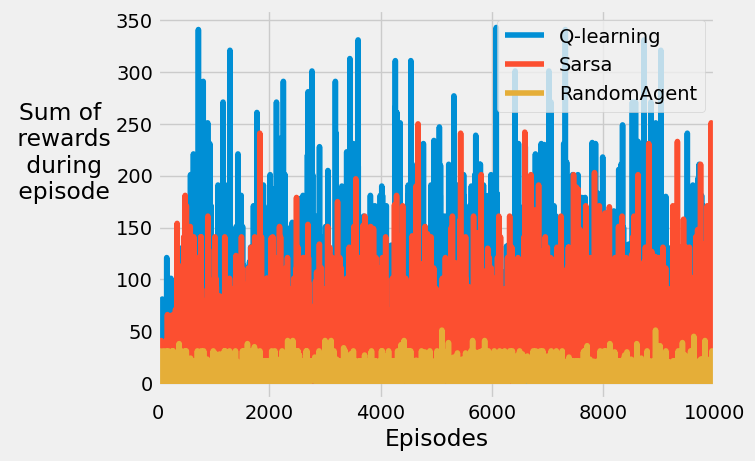

In [36]:
for algorithm in ["Q-learning", "Sarsa", "RandomAgent" ]:
    plt.plot(sums[algorithm], label=algorithm)
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,num_episodes)
plt.legend()
plt.show()

/var/folders/l4/mb15dz250cl5gh_3z6kwt4c80000gn/T/ipykernel_52186/3838267907.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


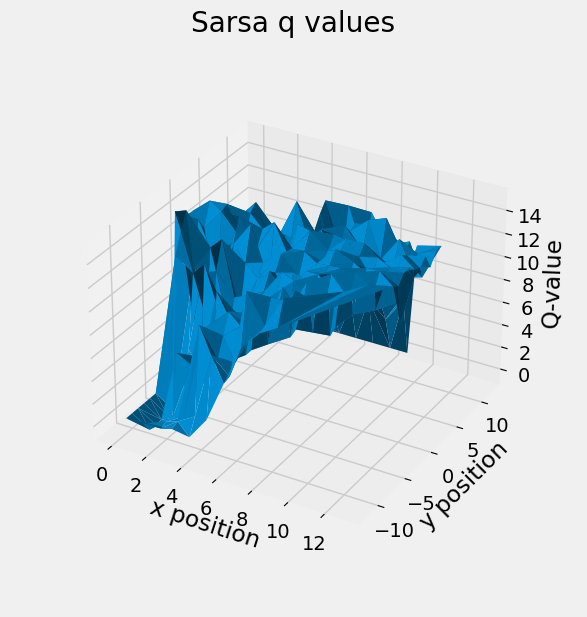

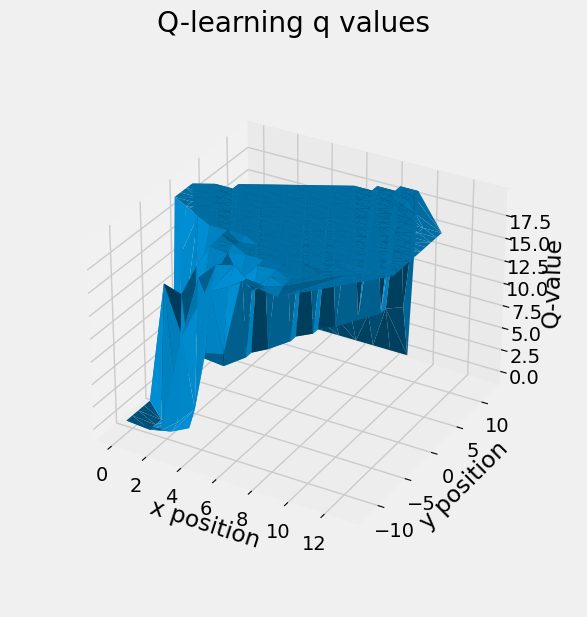

In [20]:
def plot_q_values(algo):
    q_policy = dict((k,np.max(v)) for k, v in q_tables[algo].items())
    x_list = []
    y_list = []
    z_list = []
    for key in q_policy.keys():
        x_list.append(key[0])
        y_list.append(key[1])
    for value in q_policy.values():
        z_list.append(value)
    fig = plt.figure(figsize=(12, 7))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(algo + " q values")
    ax.plot_trisurf(x_list, y_list, z_list)
    ax.set_xlabel("x position")
    ax.set_ylabel("y position")
    ax.set_zlabel("Q-value")
    ax.dist = 12
    plt.show()

plot_q_values("Sarsa")
plot_q_values("Q-learning")

## Experiments with step sizes:

In [23]:
agents = {
    "Q-learning": QLearningAgent,
    "Sarsa": SarsaAgent
}
env = gym.make('TextFlappyBird-v0',  height = 10, width = 18, pipe_gap = 4)
all_the_q_tables = {}
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
num_episodes = 1000
new_sums = {}
for algorithm in ["Q-learning", "Sarsa"]:
    for step_size in tqdm(step_sizes):
        reward_for_step = 0 
        current_agent = agents[algorithm](eps=0.2, step_size = step_size, discount=0.95)
        for episode in range(num_episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0
            while not done:
                action = current_agent.choose_action(state)
                # Apply action and return new observation of the environment
                next_state, reward, done, _, info = env.step(action)
                #For SARSA acquiring the on-policy next action
                next_action = current_agent.choose_action(next_state)
                if done == True:
                    reward = -1
                # Update total reward 
                total_reward += reward
                #Update q values table
                current_agent.update(state, action, reward, next_state, next_action)
                state = next_state
                if done:
                    break
                reward_for_step += total_reward
            new_sums[(algorithm, step_size)] = []    
            new_sums[(algorithm, step_size)].append(reward_for_step/num_episodes)
            env.close()

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


/Users/kenz/mambaforge/envs/cours_cs/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kenz/mambaforge/envs/cours_cs/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


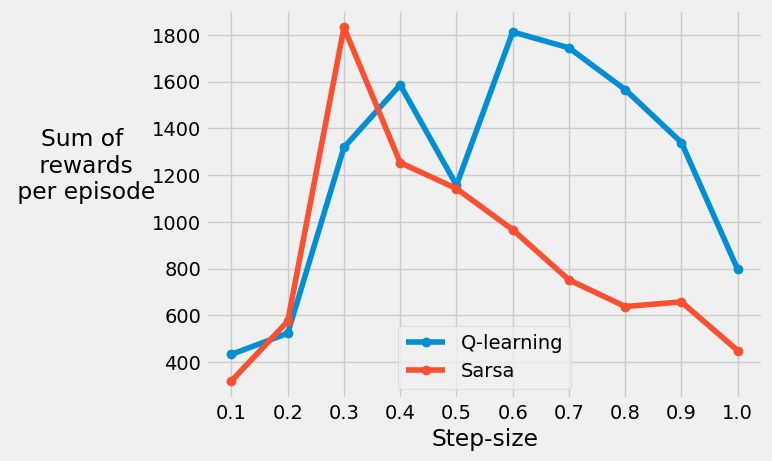

In [25]:
for algorithm in ["Q-learning", "Sarsa"]:
    algorithm_means = np.array([np.mean(new_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(new_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)
plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

In [27]:
agents = {
    "Q-learning": QLearningAgent,
    "Sarsa": SarsaAgent
}
env = gym.make('TextFlappyBird-v0',  height = 10, width = 18, pipe_gap = 4)
step_sizes = np.linspace(0.1,1.0,10)
discounts = np.linspace(0.1, 1.0, 10)
num_episodes = 5_000
discount_size_experiments = {}
for algorithm in ["Q-learning", "Sarsa"]:
    for step_size in tqdm(step_sizes):
        for discount in discounts:
            reward_for_step = 0 
            current_agent = agents[algorithm](eps=0.2, step_size = step_size, discount=discount)
            for episode in range(num_episodes):
                state, _ = env.reset()
                done = False
                total_reward = 0
                while not done:
                    action = current_agent.choose_action(state)
                    # Apply action and return new observation of the environment
                    next_state, reward, done, _, info = env.step(action)
                    #For SARSA acquiring the on-policy next action
                    next_action = current_agent.choose_action(next_state)
                    if done == True:
                        reward = -1
                    # Update total reward 
                    total_reward += reward
                    #Update q values table
                    current_agent.update(state, action, reward, next_state, next_action)
                    state = next_state
                    if done:
                        break
                    reward_for_step += total_reward
                discount_size_experiments[(algorithm, step_size, discount)] = []    
                discount_size_experiments[(algorithm, step_size, discount)].append(reward_for_step/num_episodes)
                env.close()

100%|██████████| 10/10 [04:12<00:00, 25.25s/it]


In [39]:
for step_size in step_sizes:
    for algorithm in ["Q-learning", "Sarsa"]:
        algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size, discount)]) for discount in discounts])
        algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size, discount)]) for discount in discounts])
        plt.plot(discounts, algorithm_means, marker='o', linestyle='solid', label=algorithm)
        plt.fill_between(discount, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)
    plt.legend()
    plt.xlabel("Discount rate")
    plt.ylabel(f"Sum of\n rewards\n per episode \nfor stepsize: {round( step_size , 2)}",rotation=0, labelpad=50)
    plt.xticks(discounts)
    plt.show()

NameError: name 'step_sizes' is not defined